In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
words = open('gdrive/MyDrive/Colab Notebooks/makemore/names.txt', 'r').read().splitlines()   # nomi

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
import torch

Creo il trigramma. Conto quante volte compaiono caratteri in un certo ordine e lo scrivo dentro `N_3`.

In [5]:
# _3: trigram
N_3 = torch.zeros((27, 27, 27), dtype=torch.int32)

In [6]:
chars = sorted(list(set(''.join(words))))   # alfabeto
stoi = {s:i+1 for i,s in enumerate(chars)}   # string to integer
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}   # integer to string

In [7]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    N_3[ix1, ix2, ix3] += 1

Mostro una parte di N_3, ovvero con il primo carattere fisso.

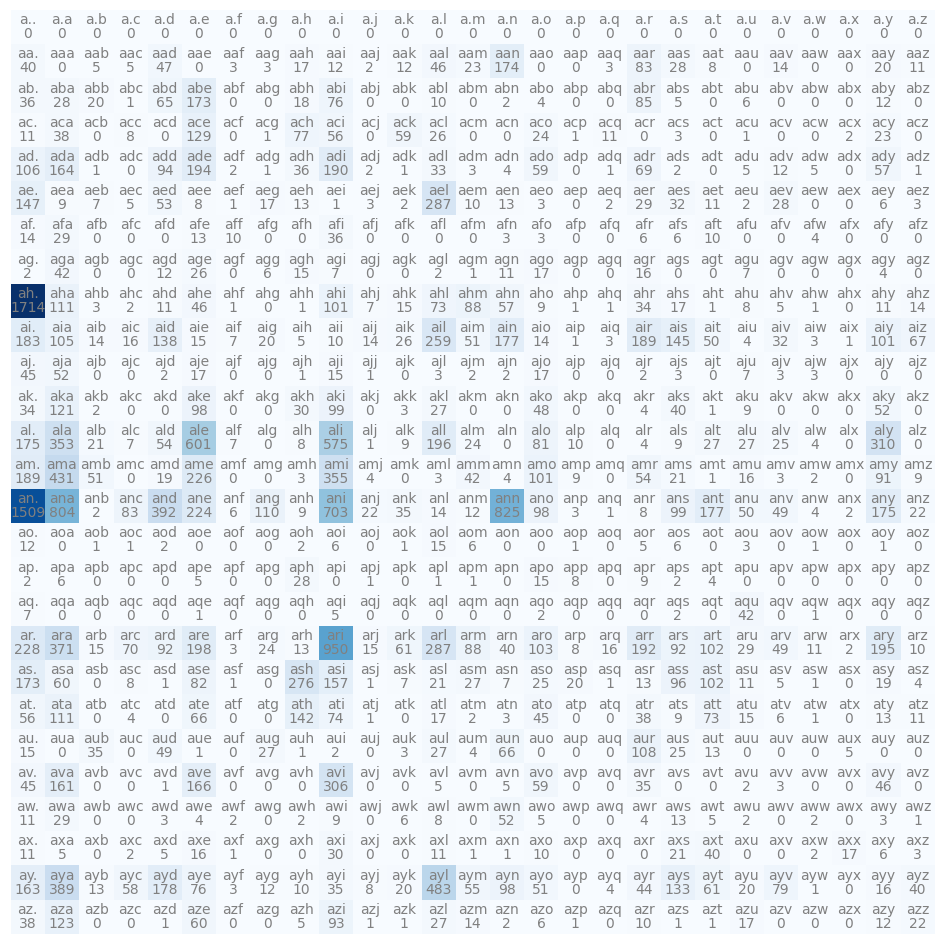

In [8]:
import matplotlib.pyplot as plt

# visualizzo 27x27 triple alla volta (scegliendo ogni volta la lettera iniziale)
k = 'a'   # scelgo la prima lettera della tripla
plt.figure(figsize=(12,12))
plt.imshow(N_3[stoi[k]], cmap='Blues')
for i in range(27):   # il secondo carattere non puo' mai essere '.'
    for j in range(27):
        chstr = k + itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N_3[stoi[k], i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

Esempio di generazione a partire da una distribuzione di probabilità multinomiale.

In [9]:
# 'an_'
p1 = N_3[stoi['a'], stoi['n']].float()
p1 = p1 / p1.sum()
p1

tensor([2.7749e-01, 1.4785e-01, 3.6778e-04, 1.5263e-02, 7.2085e-02, 4.1192e-02,
        1.1033e-03, 2.0228e-02, 1.6550e-03, 1.2928e-01, 4.0456e-03, 6.4362e-03,
        2.5745e-03, 2.2067e-03, 1.5171e-01, 1.8021e-02, 5.5167e-04, 1.8389e-04,
        1.4711e-03, 1.8205e-02, 3.2549e-02, 9.1946e-03, 9.0107e-03, 7.3556e-04,
        3.6778e-04, 3.2181e-02, 4.0456e-03])

In [10]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p1, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'.'

Calcolo le probabilità del trigramma.

In [11]:
P_3 = (N_3+1).float()   # N_3+1: incremento di 1 ogni elemento di N_3, cosi' evito che ci siano elementi di valore 0 (il log diventerebbe infinito)
P_3 /= P_3.sum(2, keepdims=True)

# P_3.shape                       --> torch.Size([27, 27, 27])
# P_3.sum(2, keepdims=True).shape --> torch.Size([27, 27, 1])

In [12]:
P_3[stoi['a'], stoi['n']]

tensor([0.2763, 0.1473, 0.0005, 0.0154, 0.0719, 0.0412, 0.0013, 0.0203, 0.0018,
        0.1288, 0.0042, 0.0066, 0.0027, 0.0024, 0.1511, 0.0181, 0.0007, 0.0004,
        0.0016, 0.0183, 0.0326, 0.0093, 0.0091, 0.0009, 0.0005, 0.0322, 0.0042])

Creo anche il bigramma, per comodità.

In [13]:
# _2: bigram

N_2 = torch.zeros((27, 27), dtype=torch.int32)

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N_2[ix1, ix2] += 1

In [14]:
P_2 = (N_2+1).float()
P_2 /= P_2.sum(1, keepdims=True)

Genero nuovi nomi a partire dalle probabilità calcolate.

In [15]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):   # genera 5 parole

  out = []
  ix = 0

  # genero il primo elemento dopo '.', consultando il bigramma
  p = P_2[ix]
  ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
  out.append(itos[ix])
  if ix == 0:
    break

  # genero gli altri elementi, consultando il trigramma
  ix1 = 0
  ix2 = ix
  while True:   # per ogni carattere, finche' non viene generato il carattere finale '.'
    p = P_3[ix1, ix2]
    ix1 = ix2
    ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()   # viene generato un carattere alla volta
    out.append(itos[ix2])
    if ix2 == 0:
      break

  print(''.join(out))

junide.
jakasid.
prelay.
adin.
kairritoper.


Misuro la qualità.

In [16]:
log_likelihood = 0.0
n = 0

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    prob = P_3[ix1, ix2, ix3]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

print(f'{log_likelihood = }')
nll = -log_likelihood
print(f'{nll = }')
print(f'{nll/n}')

log_likelihood = tensor(-410414.9688)
nll = tensor(410414.9688)
2.092747449874878
